# Исследование данных о продажах игр, оценки пользователей и экспертов, жанры и платформы.

1. Контекст задачи: нам предоставлены исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation).
2. Цель проекта: выявить определяющие успешность игры закономерности.
3. Наши задачи: выполнить предобработку данных, исследовательский анализ данных, проверить гипотезы.
4. Описание данных:

* Name — название игры
* Platform — платформа
* Year_of_Release — год выпуска
* Genre — жанр игры
* NA_sales — продажи в Северной Америке (миллионы проданных копий)
* EU_sales — продажи в Европе (миллионы проданных копий)
* JP_sales — продажи в Японии (миллионы проданных копий)
* Other_sales — продажи в других странах (миллионы проданных копий)
* Critic_Score — оценка критиков (максимум 100)
* User_Score — оценка пользователей (максимум 10)
* Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import scipy.stats as st

## Загрузка данных и вводная информация

In [12]:
pth1 = 'games.csv'
pth2 = '/datasets/games.csv'

if os.path.exists(pth1):
  data = pd.read_csv(pth1)
else:
  data = pd.read_csv(pth2)

data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Изучили данные. Сразу заметно, что в данных большое количество пропусков, а также несоответствие типов данных.

## Предобработка данных

Заменим прописные буквы в названиях столбцов на строчные.

In [18]:
data = data.rename(columns=str.lower)
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Проверим на количество пропусков.

In [21]:
data.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

Достаточно много пропусков. Не все получится заменить. Как минимум столбец rating, ведь неизвестно на какие критерии нужно обращать внимание, чтобы категоризировать подобным образом данные. Заменим те, что можем:

In [23]:
data = data.dropna(subset = ['name', 'genre', 'year_of_release'])
data['year_of_release'] = data['year_of_release'].dropna()
data.loc[data['user_score'] == 'tbd', 'user_score'] = np.nan

Поскольку в столбцах year_of_release, name, genre пропусков не так много, их можно удалить. А в столбце user_score "tbd" означает "подлежит уточнению", следовательно мы никак не можем поменять данное значение, поэтому заменили на Nan.

In [30]:
data.isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8461
user_score         8981
rating             6676
dtype: int64

Также есть столбцы critic_score, rating и user_score, в которых большое количество пропусков. Их заменить мы не можем, как и удалить. Ведь таких пропусков почти половина всех данных.

Дальше уже ничего не сделать с пропусками. Нужно хотя бы понять по какой причине они есть. Возможно, пропуски у тех игр, которые были созданы очень давно.

In [39]:
data.loc[(data['critic_score'] != data['critic_score']) & (data['year_of_release'] < 2000), 'year_of_release'].count()

1878

Действительно, четверть пропусков - это игры, вышедшие раньше 2000 года.

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  float64
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       7463 non-null   object 
 10  rating           9768 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.5+ MB


In [45]:
data['critic_score'] = pd.to_numeric(data['critic_score'], errors = 'raise')

In [46]:
data['user_score'] = pd.to_numeric(data['user_score'], errors = 'raise')
data['year_of_release'] = data['year_of_release'].astype('int')

In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       7463 non-null   float64
 10  rating           9768 non-null   object 
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB


In [51]:
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Проверим на явные и неявные дубликаты.

In [53]:
data.duplicated().sum()

0

Явных дубликатов нет.

In [55]:
data[data.duplicated(['name', 'platform', 'year_of_release', 'genre'])]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
16230,Madden NFL 13,PS3,2012,Sports,0.0,0.01,0.0,0.0,83.0,5.5,E


Есть всего 1 неявный дубликат, проверим его.

In [58]:
display(data.loc[(data['name'] == 'Madden NFL 13') & (data['platform'] == 'PS3') & (data['year_of_release'] == 2012), :])

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,Madden NFL 13,PS3,2012,Sports,2.11,0.22,0.0,0.23,83.0,5.5,E
16230,Madden NFL 13,PS3,2012,Sports,0.00,0.01,0.0,0.00,83.0,5.5,E


Как мы видим, они различаются некоторыми количественными данными. Более информативным является 604 строка, оставим ее.

In [60]:
data = data.drop([16230]).reset_index(drop = True)

Избавились от неявных дубликатов. Можем создавать столбец с суммарными продажами по регионам.

In [62]:
data['sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38


Проделав преодбработку данных, были замечены пропуски. Малоколичественные пропуски столбцов мы удалили, а оставшиеся пришлось оставить, поскольку нет замены. Также поменяли типы дынных в столбцах year_of_release, user_score. Проверили на явные и неявные дубликаты, оказался один неявный. Его удалили, оставив более информативную строку. Добавили столбец с суммарными продажами.

## Исследовательский анализ данных

### Количество игр, выпущенных в разные года.

In [70]:
games_year = data.groupby('year_of_release')['name'].count()
games_year.head()

year_of_release
1980     9
1981    46
1982    36
1983    17
1984    14
Name: name, dtype: int64

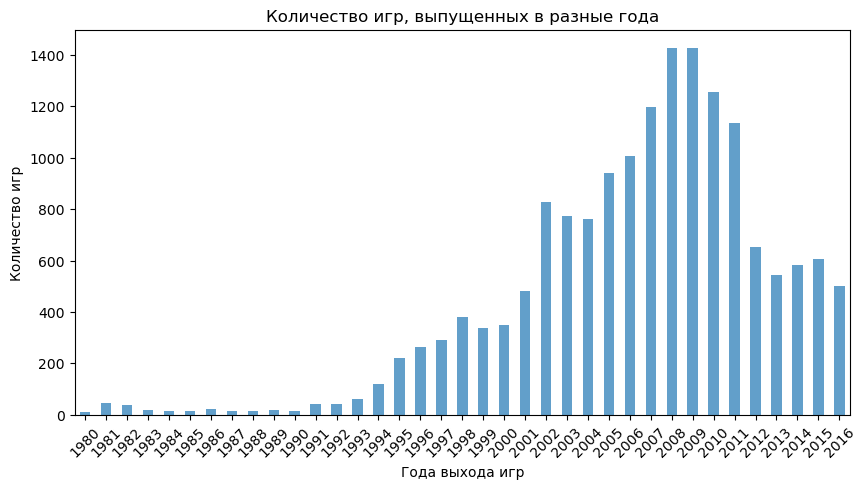

year_of_release
1980     9
1981    46
1982    36
1983    17
1984    14
Name: name, dtype: int64

year_of_release
2012    652
2013    544
2014    581
2015    606
2016    502
Name: name, dtype: int64

In [71]:
plt.figure(figsize=(10, 5))
games_year.plot(y = 'name', kind = 'bar', alpha = 0.7, title = 'Количество игр, выпущенных в разные года')
plt.xticks(rotation = 45)
plt.xlabel('Года выхода игр')
plt.ylabel('Количество игр')
plt.show()

display(games_year.head())
display(games_year.tail())

Больше всего игр вышло в 2007-2010 годах, меньше всего в 1980 году. 1980 самый непопулярный скорее всего по причине того, что это было только начало развития игр. Весь перечень годов рассматривать не имеет смысла, потому что тенденции достаточно быстро меняются, как и восприятие игр. Поэтому оптимальнее брать игры за последние 3 года.

### Как меняются продажи по платформам

Рассмотрим, какие платформы имеют наибольшие продажи.

In [79]:
sales_pl = data.groupby('platform')['sales'].sum().sort_values(ascending = False)
sales_pl.head(10)

platform
PS2     1233.56
X360     961.24
PS3      931.33
Wii      891.18
DS       802.78
PS       727.58
PS4      314.14
GBA      312.88
PSP      289.53
3DS      257.81
Name: sales, dtype: float64

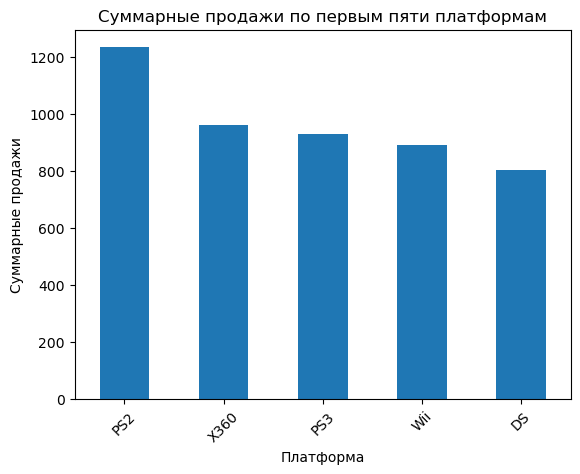

In [80]:
sales_pl = sales_pl.iloc[:5]
sales_pl.plot(y = 'sales', kind = 'bar')
plt.xticks(rotation = 45)
plt.title('Суммарные продажи по первым пяти платформам')
plt.xlabel('Платформа')
plt.ylabel('Суммарные продажи')
plt.show()

Построим распределения по годам. Но перед этим создадим сводную таблицу где индексами будут: платформы, года реализации.

In [82]:
arr = ['PS2', 'X360', 'PS3', 'Wii', 'DS']
data_top5 = data[data['platform'].isin(arr)].reset_index(drop = True)
data_top5.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
2,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
3,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E,29.80
4,Wii Play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E,28.91


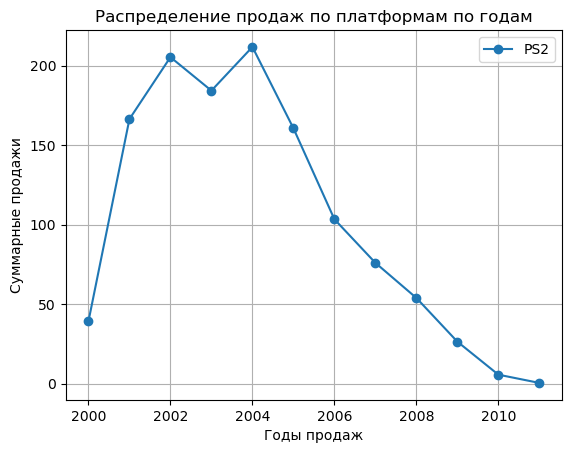

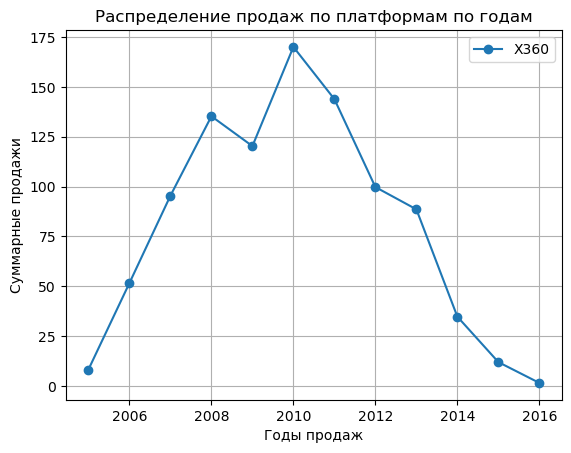

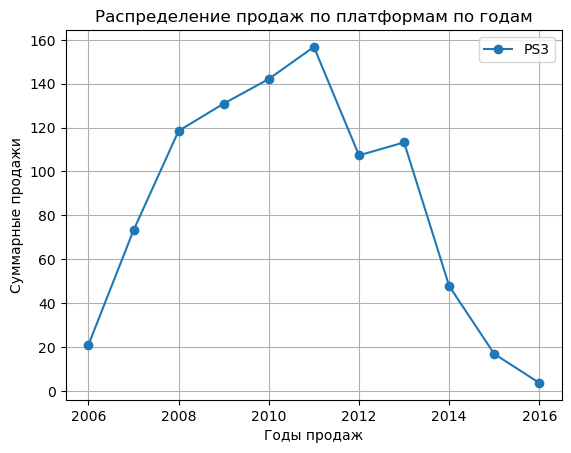

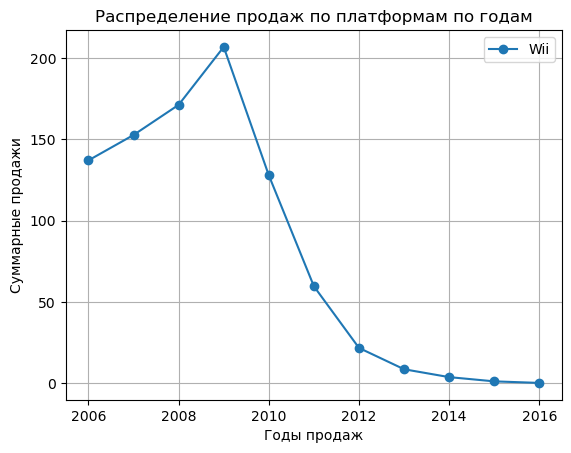

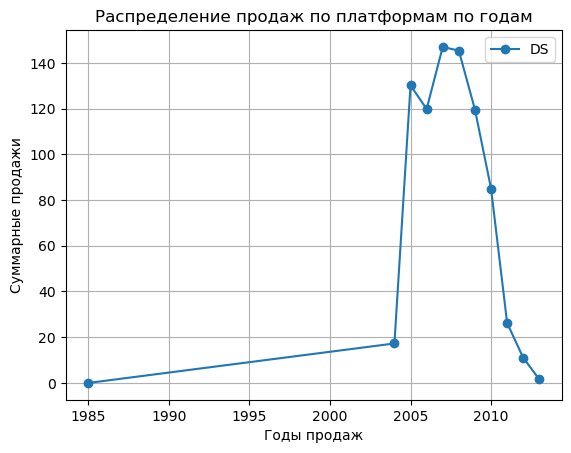

In [83]:
data_top5_pivot = data_top5.pivot_table(index = ('platform', 'year_of_release'), values = 'sales', aggfunc = 'sum').reset_index()
for i in arr:
  data_top5_pivot[data_top5_pivot['platform'] == i].plot(x = 'year_of_release', y = 'sales', style = 'o-', label = i, legend = True)
  plt.title('Распределение продаж по платформам по годам')
  plt.xlabel('Годы продаж')
  plt.ylabel('Суммарные продажи')
  plt.grid(True)
  plt.show()

Как мы можем заметить, за срок 4-6 лет появляются новые и исчезают понемногу старые. Платформа DS показала достаточно странные результаты: игра была выпущена в 1985 году, но получила свой пик только в 2005-2009 годах. Возможно, поработали маркетинговые отделы, либо вносились глобальные изменения в платформу.

Далее нам нужно будет строить прогнозы на 2017 год, но для этого нужно отобрать данные. Наиболее актуальными будут данные за последние 3 года. Предыдущие года мы рассматривать не будем.

In [91]:
data_new = data.query('year_of_release > 2013').reset_index(drop = True)
data_new.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales
0,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,14.63
1,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
2,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,NaN,NaN,NaN,11.68
3,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58
4,Star Wars Battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,NaN,NaN,NaN,7.98


Теперь у нас есть нужный для прогнозирования датафрейм с подходящими годами для рассмотрения. Рассмотрим, какие платформы лидируют, какие падают или растут.

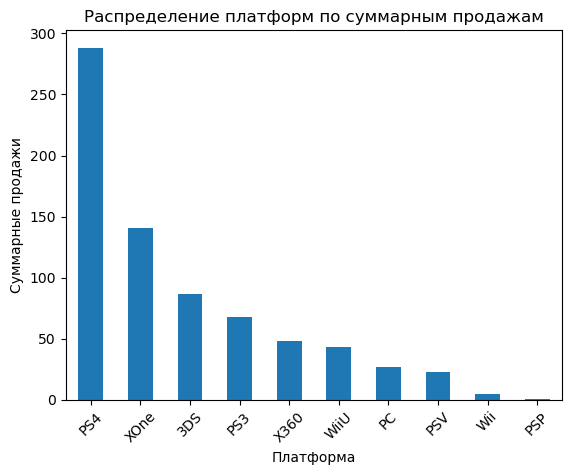

platform
PS4     288.15
XOne    140.36
3DS      86.68
PS3      68.18
X360     48.22
Name: sales, dtype: float64

platform
WiiU    42.98
PC      27.05
PSV     22.40
Wii      5.07
PSP      0.36
Name: sales, dtype: float64

In [93]:
data_new_group = data_new.groupby('platform')['sales'].sum().sort_values(ascending = False)
data_new_group.plot(y = 'sales', kind = 'bar')
plt.title('Распределение платформ по суммарным продажам')
plt.xticks(rotation = 45)
plt.xlabel('Платформа')
plt.ylabel('Суммарные продажи')
plt.show()

display(data_new_group.head())
display(data_new_group.tail())

По графику и данным ниже видно, что лидирующими платформами являются: PS4, XOne, 3DS, PS3, X360. В самом низу же находится PSP. Теперь рассмотрим, какие платформы растут, а какие падают.

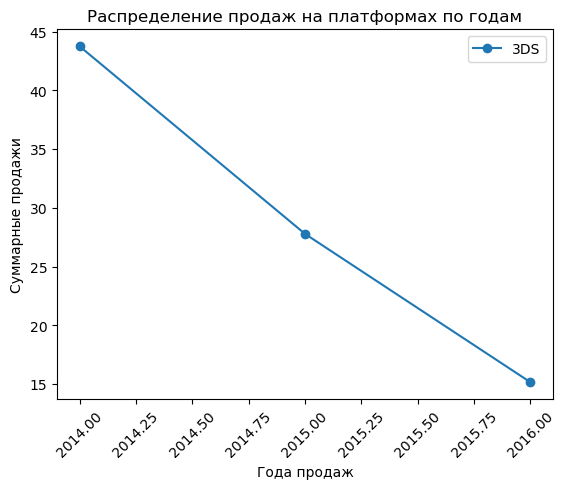

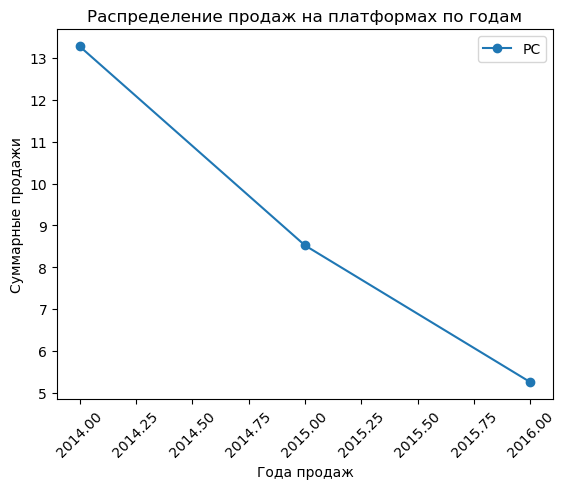

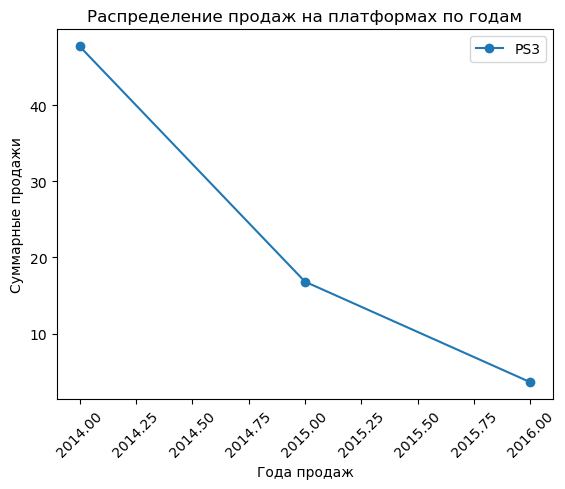

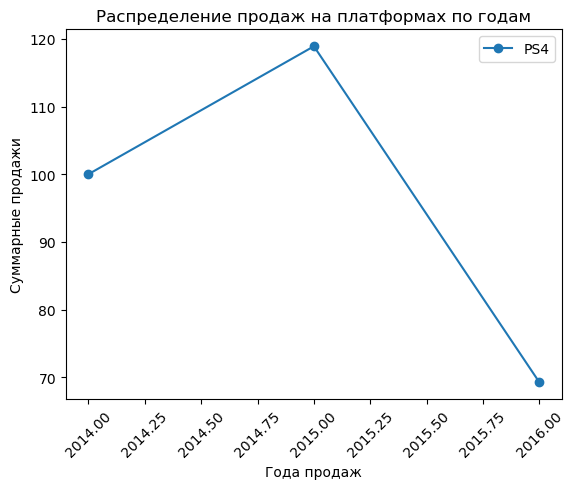

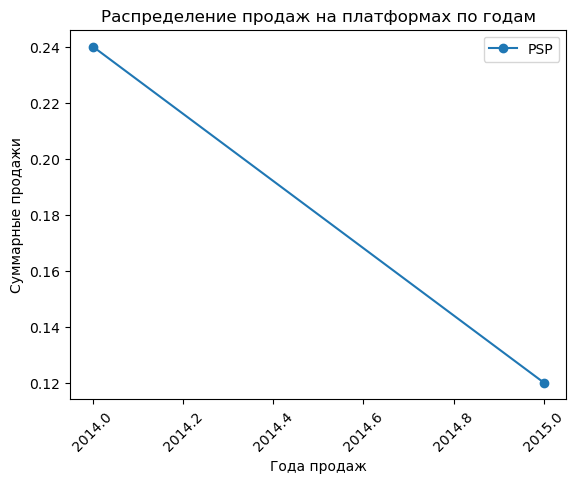

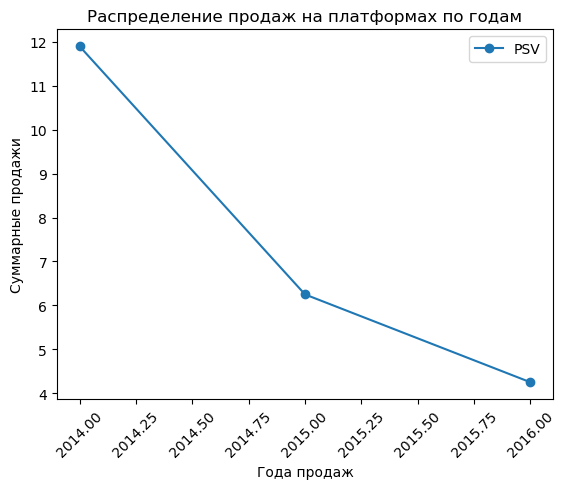

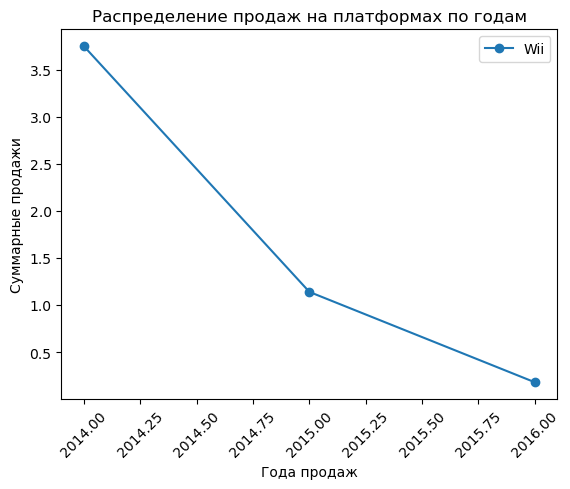

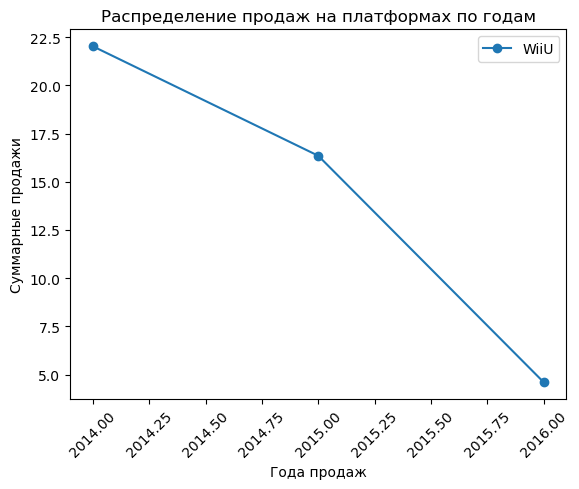

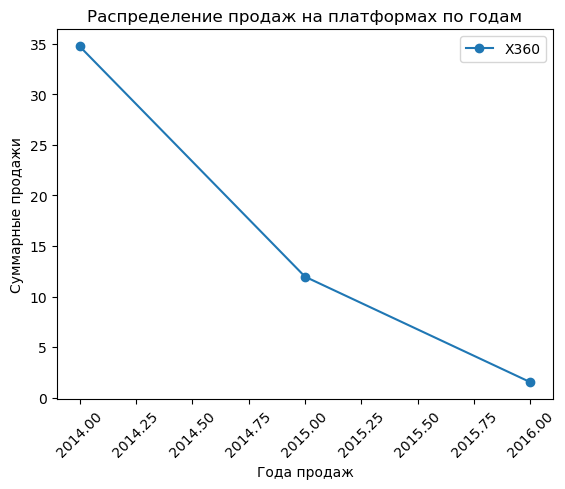

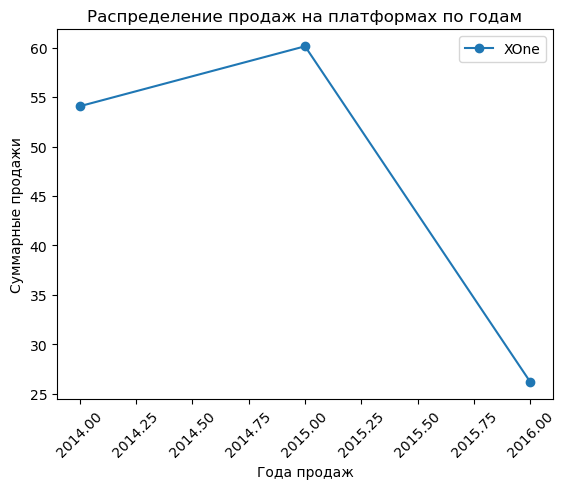

In [95]:
data_new_pivot = data_new.pivot_table(index = ('platform', 'year_of_release'), values = 'sales', aggfunc = 'sum').reset_index()
for i in data_new_pivot['platform'].unique():
  data_new_pivot[data_new_pivot['platform'] == i].plot(x = 'year_of_release', y = 'sales', style = 'o-', label = i, legend = True)
  plt.title('Распределение продаж на платформах по годам')
  plt.xticks(rotation = 45)
  plt.xlabel('Года продаж')
  plt.ylabel('Суммарные продажи')
  plt.show()

По графикам мы понимаем, что все идет на понижение. Возможно, сказывается то, что у нас данные неполного 2016 года. Но даже так можно заметить две платформы, которые имеют высокий пик в 2015 году, и в 2016 значения выше остальных. Это PS4 и XOne. Это потенциально прибыльные платформы.

###  «Ящик с усами» по глобальным продажам игр в разбивке по платформам

In [99]:
data_new.groupby('platform')['sales']
data_new.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales
0,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,14.63
1,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
2,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,NaN,NaN,NaN,11.68
3,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58
4,Star Wars Battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,NaN,NaN,NaN,7.98


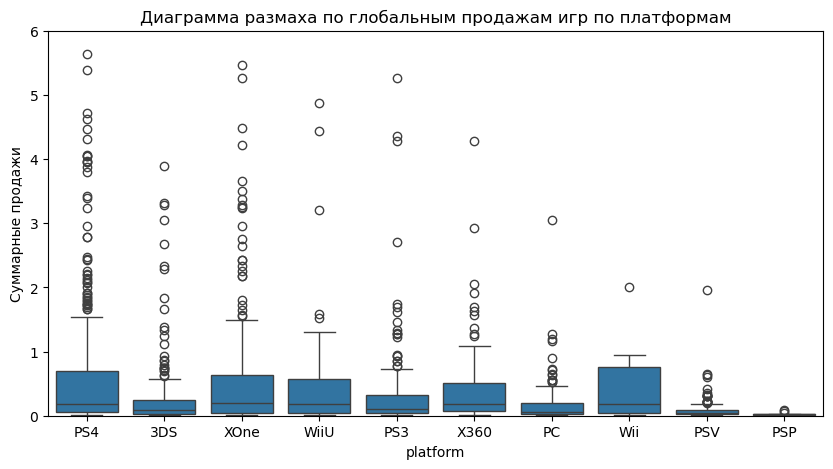

count    228.000000
mean       0.615614
std        1.046513
min        0.010000
25%        0.050000
50%        0.205000
75%        0.632500
max        7.390000
Name: sales, dtype: float64

In [100]:
plt.figure(figsize = (10, 5))
sns.boxplot(x = 'platform', y = 'sales', data = data_new)
plt.title('Диаграмма размаха по глобальным продажам игр по платформам')
plt.ylabel('Суммарные продажи')
plt.ylim(0, 6)
plt.show()

display(data_new[data_new['platform'] == i]['sales'].describe())

Рассмотрев графики, заметили, что есть большое количество аномальных выбросов среди таких платформ, как PS4, XOne, PS3, 3DS. Скорее всего это связано с продажами в 2015 году, когда у некоторых из перечисленных были взлеты в продажах. У остальных платформ таких аномальных выбросов нету.

### Влияние ответов пользователей и критиков на продажи игр

Возьмем платформу с самыми большими продажами. Это PS4.

In [107]:
plats = ['PS4', 'XOne', 'WiiU', 'PS3']
data_new_ps4 = data_new.query('platform == "PS4"')
data_new_ps4.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales
0,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,14.63
1,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
3,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58
4,Star Wars Battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,NaN,NaN,NaN,7.98
5,Call of Duty: Advanced Warfare,PS4,2014,Shooter,2.81,3.48,0.14,1.23,83.0,5.7,M,7.66


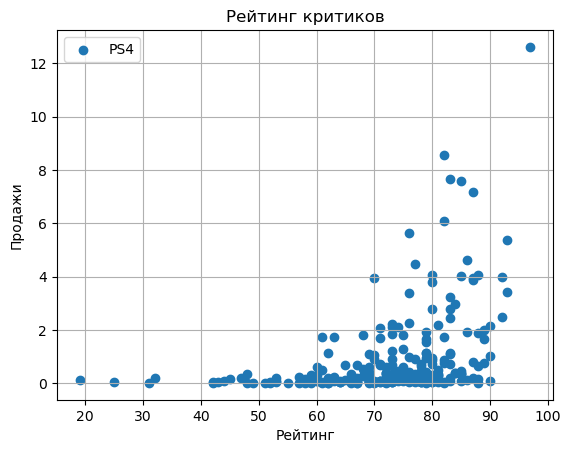

,critic_score,user_score,sales
critic_score,1.000000,0.546434,0.402661
user_score,0.546434,1.000000,-0.040132
sales,0.402661,-0.040132,1.000000


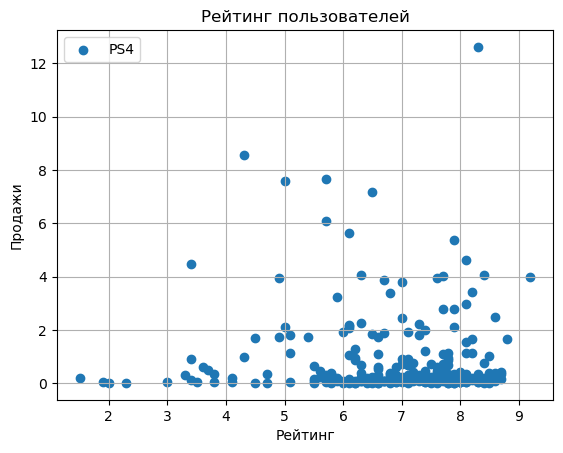

,critic_score,user_score,sales
critic_score,1.000000,0.546434,0.402661
user_score,0.546434,1.000000,-0.040132
sales,0.402661,-0.040132,1.000000


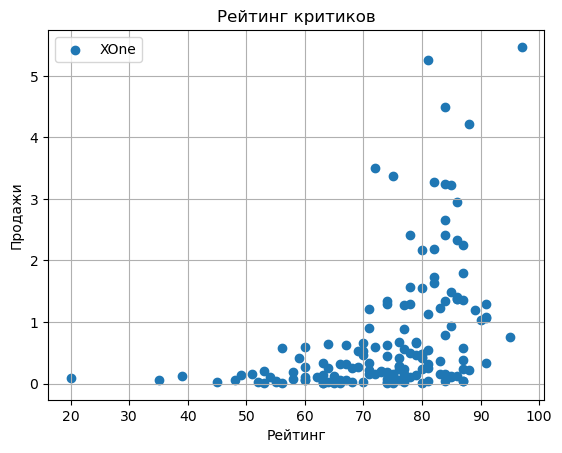

,critic_score,user_score,sales
critic_score,1.000000,0.440977,0.428677
user_score,0.440977,1.000000,-0.070384
sales,0.428677,-0.070384,1.000000


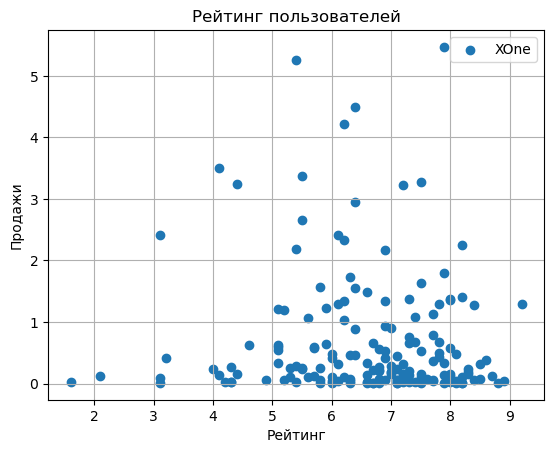

,critic_score,user_score,sales
critic_score,1.000000,0.440977,0.428677
user_score,0.440977,1.000000,-0.070384
sales,0.428677,-0.070384,1.000000


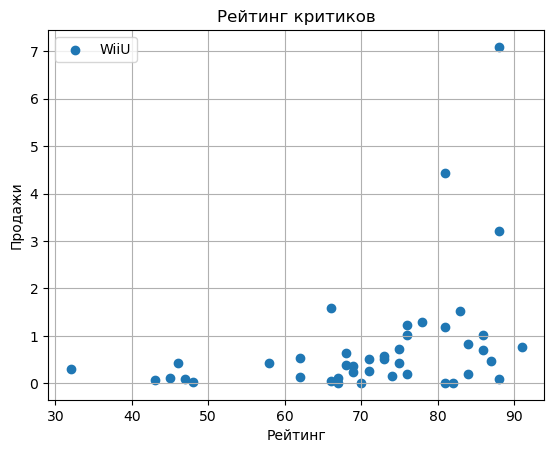

,critic_score,user_score,sales
critic_score,1.000000,0.763536,0.370201
user_score,0.763536,1.000000,0.407926
sales,0.370201,0.407926,1.000000


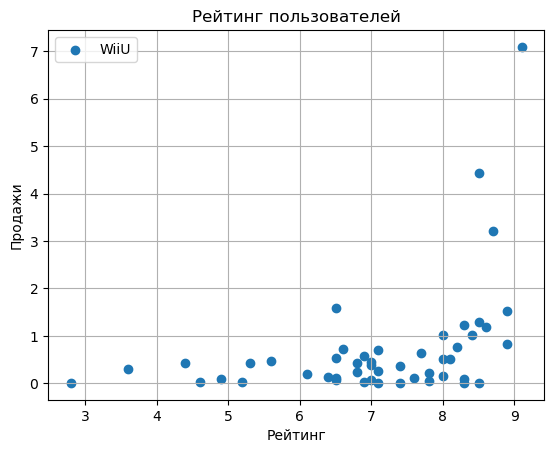

,critic_score,user_score,sales
critic_score,1.000000,0.763536,0.370201
user_score,0.763536,1.000000,0.407926
sales,0.370201,0.407926,1.000000


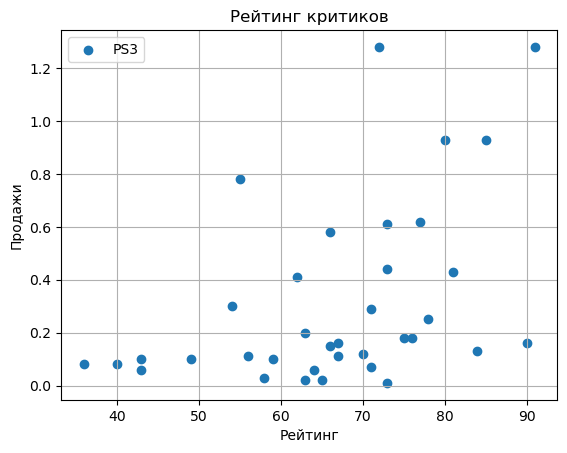

,critic_score,user_score,sales
critic_score,1.000000,0.693445,0.446575
user_score,0.693445,1.000000,-0.166761
sales,0.446575,-0.166761,1.000000


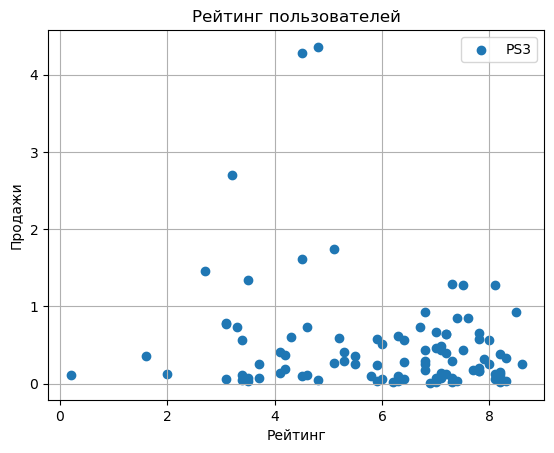

,critic_score,user_score,sales
critic_score,1.000000,0.693445,0.446575
user_score,0.693445,1.000000,-0.166761
sales,0.446575,-0.166761,1.000000


In [108]:
scores = ['critic_score', 'user_score']
for j in plats:
  for i in scores:
    plt.scatter(data_new.query('platform == @j')[i], data_new.query('platform == @j')['sales'], label = j)
    if i == 'critic_score':
      plt.title('Рейтинг критиков')
      plt.xlabel('Рейтинг')
      plt.ylabel('Продажи')
      plt.grid(True)
      plt.legend()
      plt.show()
    else:
      plt.title('Рейтинг пользователей')
      plt.xlabel('Рейтинг')
      plt.ylabel('Продажи')
      plt.grid(True)
      plt.legend()
      plt.show()

    display(data_new.query('platform == @j').loc[:, ['critic_score', 'user_score', 'sales']].corr())

Как мы видим, оценка пользователей практически никак не влияет на количество продаж. Оценка критиков имеет слабое влияние.


### Распределение игр по жанрам

Рассмотрим общее распределение игр по жанрам.

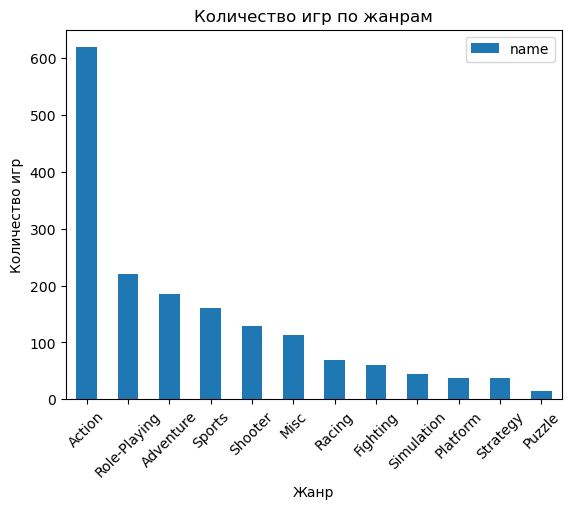

genre
Action          619
Role-Playing    221
Adventure       185
Sports          161
Shooter         128
Misc            113
Racing           69
Fighting         60
Simulation       44
Platform         38
Strategy         37
Puzzle           14
Name: name, dtype: int64

In [118]:
data_new_genre_group = data_new.groupby('genre')[['name', 'sales']].agg({'name': 'count', 'sales': 'median'}).sort_values(by = 'name', ascending = False)
data_new_genre_group.plot(y = 'name', kind = 'bar')
plt.title('Количество игр по жанрам')
plt.ylabel('Количество игр')
plt.xlabel('Жанр')
plt.xticks(rotation = 45)
plt.show()

display(data_new_genre_group['name'])

Самый популярный жанр это Action, данный жанр ушел с отрывом почти в три раза от 2 места. Менее всего популярный - Puzzle.

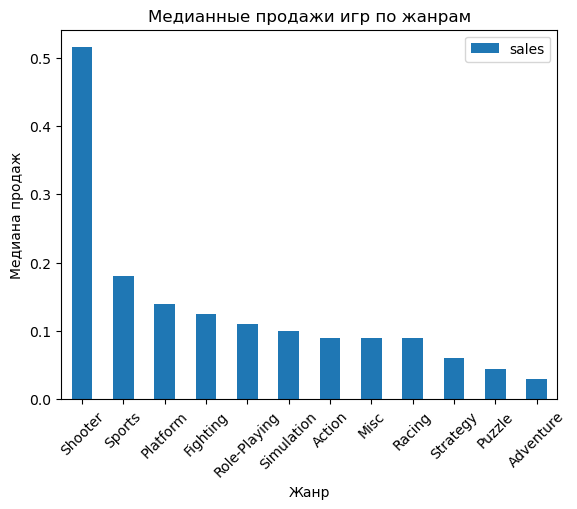

genre
Shooter         0.515
Sports          0.180
Platform        0.140
Fighting        0.125
Role-Playing    0.110
Simulation      0.100
Action          0.090
Misc            0.090
Racing          0.090
Strategy        0.060
Puzzle          0.045
Adventure       0.030
Name: sales, dtype: float64

In [120]:
data_new_genre_group = data_new_genre_group.sort_values(by = 'sales', ascending = False)
data_new_genre_group.plot(y = 'sales', kind = 'bar')
plt.title('Медианные продажи игр по жанрам')
plt.ylabel('Медиана продаж')
plt.xlabel('Жанр')
plt.xticks(rotation = 45)
plt.show()

display(data_new_genre_group['sales'])

In [121]:
data_new_genre_group.loc['Action', 'sales'] - data_new_genre_group.loc['Shooter', 'sales']

-0.42500000000000004

Количество игр по жанрам дает иной результат, нежели медианные продажи игр по жанрам. Второй график показывает, что Shooter - самый прибыльный жанр. Самый же не прибыльный - это Adventure. Жанр Shooter выделяется среди остальных своими показателями, тогда как Adventure не так сильно отстает от последующих.

## Портрет пользователя каждого региона

Определим для пользователя каждого региона (NA, EU, JP):

1. Самые популярные платформы (топ-5). Опишите различия в долях продаж.
2. Самые популярные жанры (топ-5). Поясните разницу.
3. Влияет ли рейтинг ESRB на продажи в отдельном регионе?

### Самые популярные платформы

Рассмотрим самые популярные платформы в разных регионах.

**Северная Америка:**

In [131]:
data_new.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales
0,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,14.63
1,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
2,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,NaN,NaN,NaN,11.68
3,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58
4,Star Wars Battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,NaN,NaN,NaN,7.98


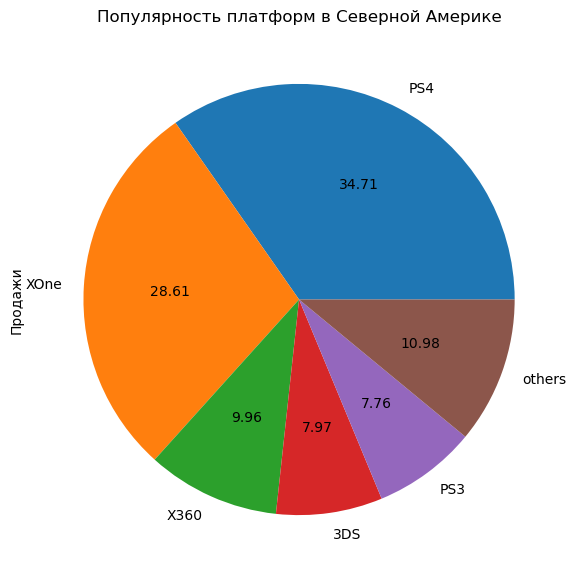

,na_sales
platform,
PS4,98.61
XOne,81.27
X360,28.30
3DS,22.64
PS3,22.05
others,31.19


In [132]:
df = data_new.groupby('platform')['na_sales'].sum().sort_values(ascending = False).reset_index()
df1 = df[:5].copy()
new_row = df['na_sales'][5:].sum()
df1.loc[len(df1.index)] = ['others', new_row]
df1 = df1.set_index('platform')


df1.plot(y = 'na_sales', kind = 'pie', autopct="%.2f", figsize = (7, 7), legend = False)
plt.title('Популярность платформ в Северной Америке')
plt.ylabel('Продажи')
plt.xticks(rotation = 45)
plt.show()

display(df1)

Топ-5 самых популярных платформ среди пользователей в Северной Америке:
* PS4 (0.35 от всех продаж)
* X360 (0.29 от всех продаж)
* 3DS (0.1 от всех продаж)
* PS3 (0.08 от всех продаж)
* WiiU (0.07 от всех продаж)

**Европа:**

In [137]:
data_new.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales
0,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,14.63
1,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
2,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,NaN,NaN,NaN,11.68
3,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58
4,Star Wars Battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,NaN,NaN,NaN,7.98


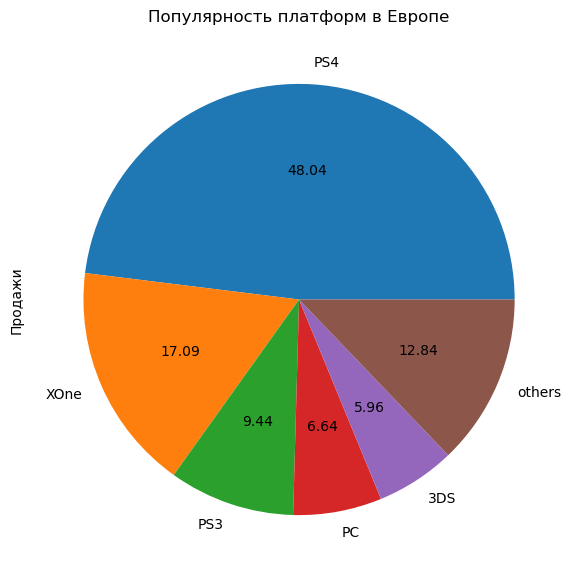

,eu_sales
platform,
PS4,130.04
XOne,46.25
PS3,25.54
PC,17.97
3DS,16.12
others,34.76


In [138]:
df = data_new.groupby('platform')['eu_sales'].sum().sort_values(ascending = False).reset_index()
df1 = df[:5].copy()
new_row = df['eu_sales'][5:].sum()
df1.loc[len(df1.index)] = ['others', new_row]
df1 = df1.set_index('platform')


df1.plot(y = 'eu_sales', kind = 'pie', autopct="%.2f", figsize = (7, 7), legend = False)
plt.title('Популярность платформ в Европе')
plt.ylabel('Продажи')
plt.xticks(rotation = 45)
plt.show()

display(df1)

Топ-5 самых популярных платформ среди пользователей в Европе:
* PS4 (0.48 от всех продаж)
* XOne (0.17 от всех продаж)
* PS3 (0.09 от всех продаж)
* PC (0.07 от всех продаж)
* 3DS (0.06 от всех продаж)

**Япония:**

In [141]:
data_new.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales
0,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,14.63
1,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
2,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,NaN,NaN,NaN,11.68
3,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58
4,Star Wars Battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,NaN,NaN,NaN,7.98


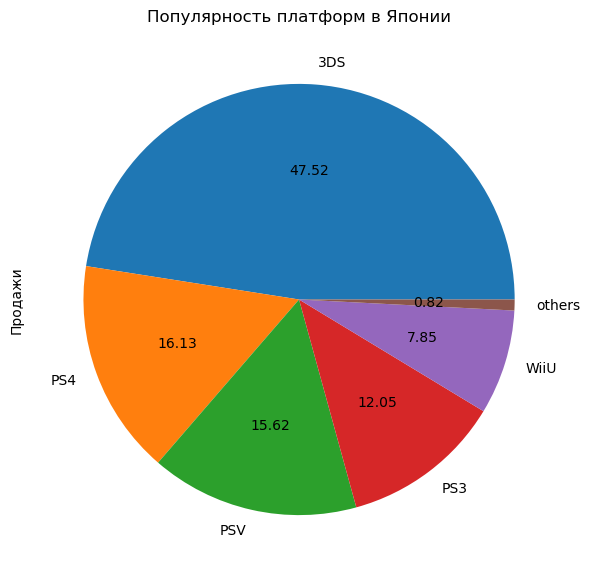

,jp_sales
platform,
3DS,44.24
PS4,15.02
PSV,14.54
PS3,11.22
WiiU,7.31
others,0.76


In [142]:
df = data_new.groupby('platform')['jp_sales'].sum().sort_values(ascending = False).reset_index()
df1 = df[:5].copy()
new_row = df['jp_sales'][5:].sum()
df1.loc[len(df1.index)] = ['others', new_row]
df1 = df1.set_index('platform')


df1.plot(y = 'jp_sales', kind = 'pie', autopct="%.2f", figsize = (7, 7), legend = False)
plt.title('Популярность платформ в Японии')
plt.ylabel('Продажи')
plt.xticks(rotation = 45)
plt.show()

display(df1)

Топ-5 самых популярных платформ среди пользователей в Японии:
* 3DS (0.48 от всех продаж)
* PS4 (0.16 от всех продаж)
* PSV (0.16 от всех продаж)
* PS3 (0.12 от всех продаж)
* WiiU (0.08 от всех продаж)

В Америке и Европе популярнее PS4 с долями 0.35 и 0.48 соответственно. В Японии же PS4 занимает второе место с долей 0.16, а на первом месте 3DS с долей 0.48. В Америке и Японии 5 место занимает WiiU, когда в Европе такой платформы нет в топе, а на последнем месте в том регионе 3DS.

### Самые популярные жанры

Рассмотрим самые популярные жанры в разных регионах.

**Северная Америка:**

In [149]:
data_new.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales
0,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,14.63
1,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
2,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,NaN,NaN,NaN,11.68
3,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58
4,Star Wars Battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,NaN,NaN,NaN,7.98


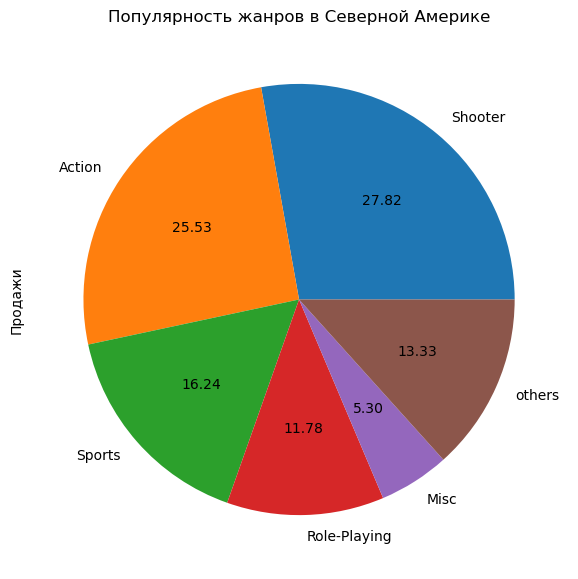

,na_sales
genre,
Shooter,79.02
Action,72.53
Sports,46.13
Role-Playing,33.47
Misc,15.05
others,37.86


In [273]:
df = data_new.groupby('genre')['na_sales'].sum().sort_values(ascending = False).reset_index()
df1 = df[:5].copy()
new_row = df['na_sales'][5:].sum()
df1.loc[len(df1.index)] = ['others', new_row]
df1 = df1.set_index('genre')


df1.plot(y = 'na_sales', kind = 'pie', autopct="%.2f", figsize = (7, 7), legend = False)
plt.title('Популярность жанров в Северной Америке')
plt.ylabel('Продажи')
plt.xticks(rotation = 45)
plt.show()

display(df1)

Топ-5 самых популярных жанров среди пользователей в Северной Америке:
* Shooter (0.28 от всех продаж)
* Action (0.26 от всех продаж)
* Sports (0.16 от всех продаж)
* Role-Playing (0.12 от всех продаж)
* Misc (0.05 от всех продаж)

**Европа:**

In [153]:
data_new.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales
0,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,14.63
1,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
2,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,NaN,NaN,NaN,11.68
3,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58
4,Star Wars Battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,NaN,NaN,NaN,7.98


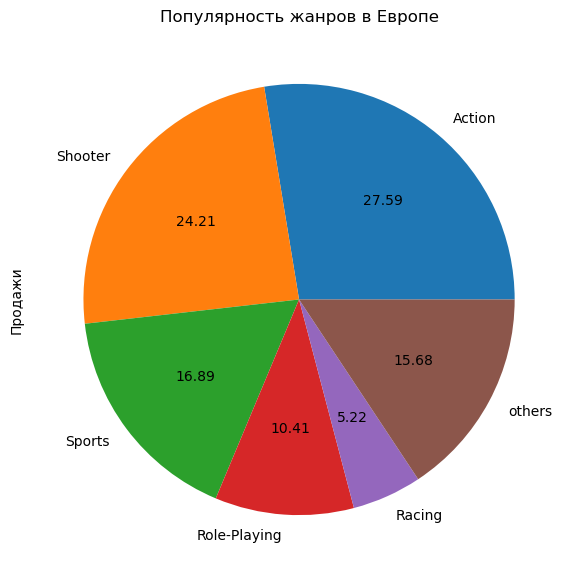

,eu_sales
genre,
Action,74.68
Shooter,65.52
Sports,45.73
Role-Playing,28.17
Racing,14.13
others,42.45


In [154]:
df = data_new.groupby('genre')['eu_sales'].sum().sort_values(ascending = False).reset_index()
df1 = df[:5].copy()
new_row = df['eu_sales'][5:].sum()
df1.loc[len(df1.index)] = ['others', new_row]
df1 = df1.set_index('genre')


df1.plot(y = 'eu_sales', kind = 'pie', autopct="%.2f", figsize = (7, 7), legend = False)
plt.title('Популярность жанров в Европе')
plt.ylabel('Продажи')
plt.xticks(rotation = 45)
plt.show()

display(df1)

Топ-5 самых популярных жанров среди пользователей в Европе:

* Action (0.28 от всех продаж)
* Shooter (0.24 от всех продаж)
* Sports (0.17 от всех продаж)
* Role-Playing (0.1 от всех продаж)
* Racing (0.05 от всех продаж)

**Япония:**

In [157]:
data_new.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales
0,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,14.63
1,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
2,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,NaN,NaN,NaN,11.68
3,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58
4,Star Wars Battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,NaN,NaN,NaN,7.98


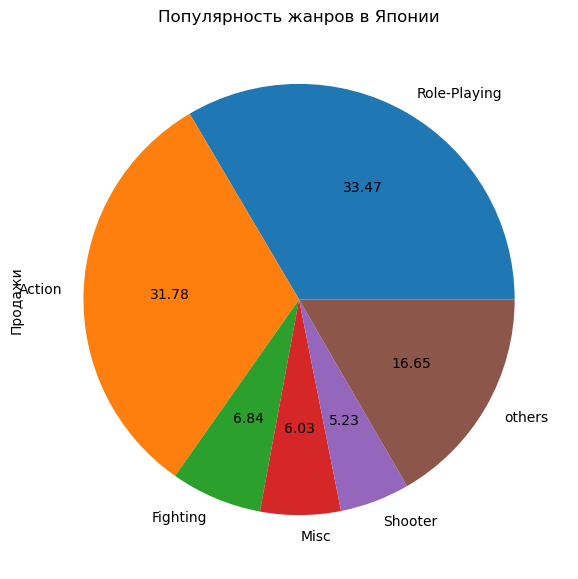

,jp_sales
genre,
Role-Playing,31.16
Action,29.58
Fighting,6.37
Misc,5.61
Shooter,4.87
others,15.50


In [158]:
df = data_new.groupby('genre')['jp_sales'].sum().sort_values(ascending = False).reset_index()
df1 = df[:5].copy()
new_row = df['jp_sales'][5:].sum()
df1.loc[len(df1.index)] = ['others', new_row]
df1 = df1.set_index('genre')


df1.plot(y = 'jp_sales', kind = 'pie', autopct="%.2f", figsize = (7, 7), legend = False)
plt.title('Популярность жанров в Японии')
plt.ylabel('Продажи')
plt.xticks(rotation = 45)
plt.show()

display(df1)

Топ-5 самых популярных жанров среди пользователей в Японии:

* Role-Playing (0.33 от всех продаж)
* Action (0.32 от всех продаж)
* Fighting (0.07 от всех продаж)
* Misc (0.06 от всех продаж)
* Shooter (0.05 от всех продаж)

В Америке и Европе схожие вкусы по жанрам за исключением 5 места у того и другого региона: Misc и Racing соответственно. В Японии же на первом месте Role-Playing, на последнем Shooter, когда у остальных регионов данный жанр на местах выше. В итоге самые популярные жанры среди всех регионов: Action, Shooter, Role-playing.

### Влияет ли рейтинг ESRB на продажи в отдельном регионе?

In [163]:
data_new['rating'] = data_new['rating'].fillna('Unknown')

In [164]:
data_new.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales
0,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,Unknown,14.63
1,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
2,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,NaN,NaN,Unknown,11.68
3,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58
4,Star Wars Battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,NaN,NaN,Unknown,7.98


**Северная Америка:**

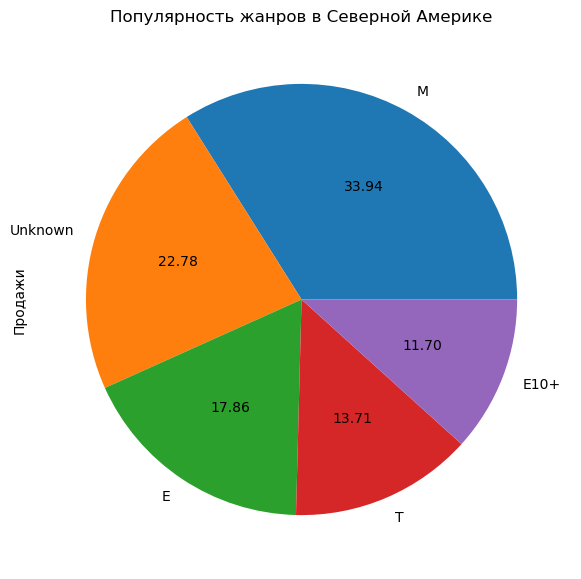

,na_sales
rating,
M,96.42
Unknown,64.72
E,50.74
T,38.95
E10+,33.23


In [166]:
df = data_new.groupby('rating')['na_sales'].sum().sort_values(ascending = False).reset_index()
df = df.set_index('rating')


df.plot(y = 'na_sales', kind = 'pie', autopct="%.2f", figsize = (7, 7), legend = False)
plt.title('Популярность жанров в Северной Америке')
plt.ylabel('Продажи')
plt.xticks(rotation = 45)
plt.show()

display(df)

Игры с рейтингом M самые продаваемые, он ушел с отрывом и занимает почти половину всех продаж, а E10+ самый не продаваемый.

**Европа:**

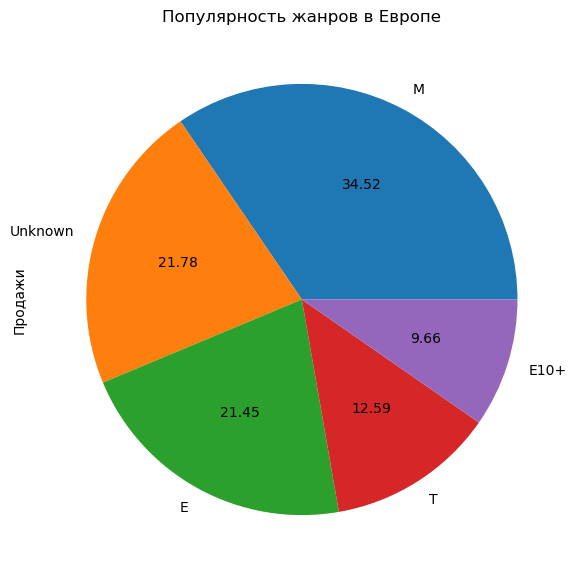

,eu_sales
rating,
M,93.44
Unknown,58.95
E,58.06
T,34.07
E10+,26.16


In [169]:
df = data_new.groupby('rating')['eu_sales'].sum().sort_values(ascending = False).reset_index()
df = df.set_index('rating')


df.plot(y = 'eu_sales', kind = 'pie', autopct="%.2f", figsize = (7, 7), legend = False)
plt.title('Популярность жанров в Европе')
plt.ylabel('Продажи')
plt.xticks(rotation = 45)
plt.show()

display(df)

Как и в Америке самый продаваемый рейтинг - это M, самый не продаваемый - это E10+.

**Япония:**

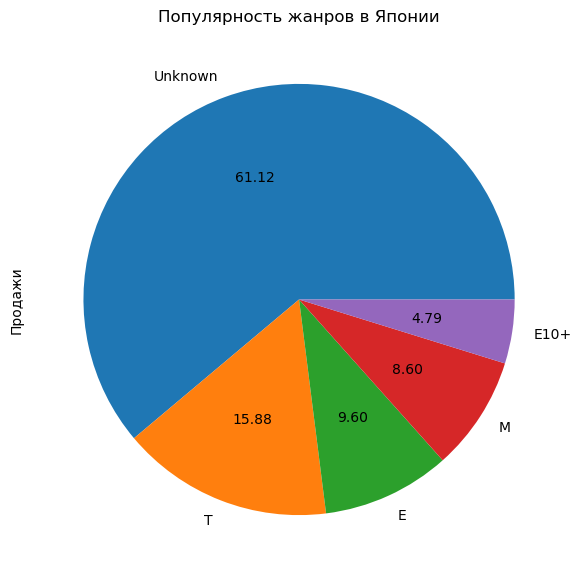

,jp_sales
rating,
Unknown,56.90
T,14.78
E,8.94
M,8.01
E10+,4.46


In [172]:
df = data_new.groupby('rating')['jp_sales'].sum().sort_values(ascending = False).reset_index()
df = df.set_index('rating')


df.plot(y = 'jp_sales', kind = 'pie', autopct="%.2f", figsize = (7, 7), legend = False)
plt.title('Популярность жанров в Японии')
plt.ylabel('Продажи')
plt.xticks(rotation = 45)
plt.show()

display(df)

Неизвестные нам рейтинги на первом месте по продажам в Японии с очень большим отрывом. А E10+ - самый не продаваемый.

Можно сделать вывод, что игры с рейтингом M имеют больший спрос, чем остальные. А самый малоспросный рейтинг - это E10+. Но так же следует сказать, что результаты могут сильно поменяться, если предоставят достоверные данные о рейтинке ESRB.

## Проверка гипотез

Перед тем как проверять гипотезы, нужно устранить все пропуски. Заменим их на -1.

In [184]:
data_new['user_score'] = data_new['user_score'].fillna(-1)

In [185]:
data_new['user_score'].unique()

array([-1. ,  8.3,  4.3,  5.7,  5. ,  6.5,  9.1,  6.1,  7.9,  5.4,  8.1,
        6.4,  3.4,  8.5,  4.8,  4.9,  4.5,  6.2,  8.4,  6.3,  7.7,  9.2,
        7.6,  8.7,  6.7,  7. ,  4.1,  8.2,  6.8,  5.5,  7.5,  4.4,  5.9,
        7.2,  6.9,  3.9,  4.2,  3.2,  8.6,  3.1,  9. ,  7.3,  7.4,  6. ,
        4.7,  7.1,  8.8,  5.1,  6.6,  3. ,  5.8,  2.9,  8.9,  2.7,  8. ,
        3.5,  7.8,  5.2,  5.6,  4.6,  3.3,  9.3,  4. ,  3.6,  3.7,  2.4,
        2.8,  5.3,  1.7,  1.6,  3.8,  1.5,  0.7,  2.5,  2. ,  2.1,  0.2,
        1.9,  1.4,  2.3])

Теперь все в порядке, можем приступать к проверке гипотез.

1. Нулевая гипотеза: средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Альтернативная гипотеза: средние пользовательские рейтинги платформ Xbox One и PC не одинаковые

In [189]:
sample1 = data_new.loc[(data_new['platform'] == 'XOne') & (data_new['user_score'] >= 0), 'user_score']
sample2 = data_new.loc[(data_new['platform'] == 'PC') & (data_new['user_score'] >= 0), 'user_score']
alpha = 0.05
results = st.ttest_ind(sample1, sample2)
print('p-value:', results.pvalue)
if results.pvalue > alpha:
  print('Не получилось отвергнуть нулевую гипотезу')
else:
  print('Отвергаем нулевую гипотезу')

p-value: 0.10450507919348416
Не получилось отвергнуть нулевую гипотезу


Не получилось отвергнуть нулевую гипотезу в пользу альтернативной.

2. Нулевая гипотеза: средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») одинаковые.

Альтернативная гипотеза: средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

In [202]:
sample1 = data_new.loc[(data_new['genre'] == 'Action') & (data_new['user_score'] >= 0), 'user_score']
sample2 = data_new.loc[(data_new['genre'] == 'Sports') & (data_new['user_score'] >= 0), 'user_score']
alpha = 0.05
results = st.ttest_ind(sample1, sample2)
print('p-value:', results.pvalue)
if results.pvalue > alpha:
  print('Не получилось отвергнуть нулевую гипотезу')
else:
  print('Отвергаем нулевую гипотезу')

p-value: 2.871114798510586e-19
Отвергаем нулевую гипотезу


Отвергаем нулевую гипотезу в пользу альтернативной. С большой вероятностью средние пользовательские рейтинги жанров Action и Sports разные.

Нулевые и альтернативные гипотезы были сформулированы по принципу: нулевая гипотеза должна гласить о равенстве двух рассматриваемых объектов, а альтернативная по условию задачи: либо не равны, либо больше, либо меньше.

Поскольку у нас независимые выборки, использовался двухвыборочный t-тест для независимых выборок.

# Вывод

1. Нам был дан кейс, и мы провели предобратку данных, исследовательный анализ, а также сделали проверку гипотез. Проведя предобработку данных были замечены пропуски. Пропуски в трех столбцах были удалены, поскольку их было малое количество. Столбцы critic_score, user_score и rating обработать не вышло, поскольку нет достаточно данных для замены пропусков. Также нашли неявный дубликат, от него избавились путем удаления. После чего успешно изменили типы данных. В ходе исследовательского анализа данных выяснили, что больше всего игр было выпущено в 2007 году, меньше всего в 1980 году. Определили, что лучше всего брать информацию за последние три года. За срок 4-6 лет появляются новые и исчезают понемногу старые платформы. Рассмотрев графики, заметили, что есть большое количество аномальных выбросов среди таких платформ, как PS4, XOne, PS3, 3DS. Скорее всего это связано с продажами в 2015 году, когда у некоторых из перечисленных были взлеты в продажах. У остальных платформ таких аномальных выбросов нету. Определили, что оценка пользователей практически никак не влияет на количество продаж, а оценка критиков имеет слабое влияние. Выяснили также, что самый продаваемый жанр это Shooter с большим отрывом. Менее всего продаваемый - Adventure. Жанры с высокими и низкими продажами выделяются. Составив портрет пользователей по регионам, выявили: в Америке и Европе популярнее PS4, в Японии же PS4 занимает второе место с долей, а на первом месте 3DS. В Америке и Японии 5 место занимает WiiU, когда в Европе такой платформы нет в топе, а на последнем месте в том регионе 3DS. Больше всего продаваемые игры это те, у которых рейтинг M от ESRB. Менее всего продаваемые игры с рейтингом E10+ Далее проверили гипотезы, которые могут помочь выявить нужные закономерности.

* В итоге проделанной работы мы смогли узнать нужные закономерности.
* Рекомендации для заказчиков: Гипотезы, на которые стоит обратить внимание:
1.  Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.
2. Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные. Жанр Action имеет более высокие средние показатели среди пользовательских рейтингов.

* Рекомендации для отдела маркетинга:

Платформы, которые имеют перспективу вырасти в следующих годах:
1. PS4
2. XOne
3. WiiU

Самые популярные жанры среди всех регионов:
1. Action
2. Shooter
3. Role-playing

Оценки пользователей можно не учитывать, а оценки критиков имеют слабое влияние. Самый продаваемые игры с рейтингом M, самые не продаваемые - E10+.